## Welcome to the Tensorflow Mobilenet transfer learning workshop!
### Here we are going to learn how to take a pretrained Mobilenet V2 from Keras and use transfer learning to apply it to a new dataset.

In [ ]:
!pip install tqdm

In [23]:
%pylab inline
import boto3, re, os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow
import tarfile
import tensorflow as tf
from glob import glob
import numpy as np
import subprocess
from tqdm import tqdm
import cv2

role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()

Populating the interactive namespace from numpy and matplotlib


Let's first download the data, we are going to be working with the Caltech256 dataset

In [39]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar .
!tar -xvf 256_ObjectCategories.tar 

--2020-05-04 15:21:49--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1183006720 (1.1G) [application/x-tar]
Saving to: ‘256_ObjectCategories.tar’

256_ObjectCategorie 100%[===================>]   1.10G  12.2MB/s    in 2m 49s  

2020-05-04 15:24:38 (6.69 MB/s) - ‘256_ObjectCategories.tar’ saved [1183006720/1183006720]

--2020-05-04 15:24:38--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-05-04 15:24:38--
Total wall clock time: 2m 49s
Downloaded: 1 files, 1.1G in 2m 49s (6.69 MB/s)
256_ObjectCategories/
256_ObjectCategories/001.ak47/
256_ObjectCategories/001.ak47/001_0001.jpg
256_ObjectCategories/001.ak47/001_0002.jpg
256_ObjectCategories/001.ak47/00

Unfortunately, if we want to use multiple GPUs in Keras, currently we cannot simply access images from a directory, we instead need our images to be in the format of a Numpy array. 

In [24]:
categories = {}
folders = os.listdir('256_ObjectCategories/')
folders.sort()
for d in folders:
    files = glob(f'256_ObjectCategories/{d}/*.jpg')
    files.sort()
    categories[d] = files
    
# since there are not the same amount of images for each category we are going to want to even them out.
ls = []
for cat in categories:
    l = len(categories[cat])
    ls.append(l)
    
examples = min(ls)
ex_ind = np.argmin(ls)
print(f'Minimum number of examples is {examples}')

Minimum number of examples is 80


We will load our images using OpenCV, these specific images are in RBG format, so in order to 

In [25]:
imgs = []
labs = []

for j,cat in tqdm(enumerate(categories)):
    for i,file in enumerate(categories[cat]):
        img = cv2.imread(file)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(np.array(img))
        labs.append(j)

img_arr = np.array(imgs) # , dtype=np.float32
labels = tf.keras.utils.to_categorical(labs)
del imgs, labs

257it [00:57,  4.46it/s]


Let's take a look at one of the images

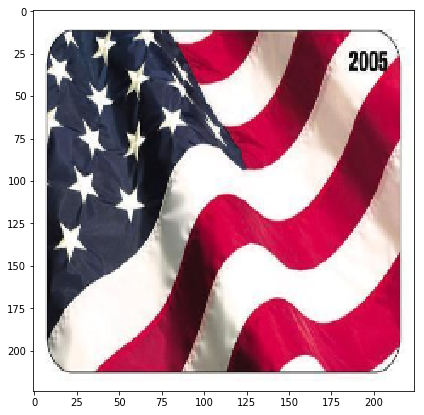

In [26]:
plt.figure(figsize=(14,7))
plt.imshow(img_arr[98])

Let's split our data into train and test sets

In [8]:
split = .8
inds = np.arange(img_arr.shape[0])
np.random.shuffle(inds)
train_x = img_arr[:(int(inds.shape[0]*split))]
train_y = labels[:(int(inds.shape[0]*split))]
test_x = img_arr[(int(inds.shape[0]*split)):]
test_y = labels[(int(inds.shape[0]*split)):]

Now we need to save our data and move it to s3 so that your model can access it.

In [168]:
!mkdir data
np.save('data/train_data.npy',train_x)
np.save('data/train_labels.npy',train_y)
np.save('data/eval_data.npy',test_x)
np.save('data/eval_labels.npy',test_y)


mkdir: cannot create directory ‘data’: File exists


In [5]:
!aws s3 cp --recursive data s3://$bucket/caltech256

upload: data/eval_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_labels.npy
upload: data/train_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_labels.npy
upload: data/eval_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_data.npy
upload: data/train_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_data.npy


Here we specify our estimator and training script that will get executed on a training instance. We can specify the type of instances and number of instances to run training on when we specify our estimator. Let's take a look at mobile_keras.py.

In [47]:
training_data_uri = f's3://{bucket}/caltech256/'
output_uri = f's3://{bucket}/mobilenet/'

mobile_estimator = TensorFlow(
                              entry_point='mobile_keras.py', # this points to the script that will execute training
                              model_dir=output_uri, # where the model will eventually be saved
                             role=role,
                             train_instance_count=1, 
                             train_instance_type='ml.p3.8xlarge',
                             framework_version='2.1',
                             py_version='py3',
                              script_mode=True,
                             distributions={'parameter_server': {'enabled': True}})


You have selected a multi-GPU training instance type. You have also enabled parameter server for distributed training. Distributed training with the default parameter server configuration will not fully leverage all GPU cores; the parameter server will be configured to run only one worker per host regardless of the number of GPUs.


In [48]:
%time mobile_estimator.fit(training_data_uri)

2020-05-05 21:03:20 Starting - Starting the training job...
2020-05-05 21:03:22 Starting - Launching requested ML instances......
2020-05-05 21:04:31 Starting - Preparing the instances for training.........
2020-05-05 21:06:12 Downloading - Downloading input data.........
2020-05-05 21:07:38 Training - Downloading the training image..2020-05-05 21:08:03,747 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training

2020-05-05 21:08:00 Training - Training image download completed. Training in progress.2020-05-05 21:08:11,491 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir":

UnexpectedStatusException: Error for Training job tensorflow-training-2020-05-05-21-03-20-165: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python3 mobile_keras.py --model_dir s3://sagemaker-us-east-1-209419068016/mobilenet/"

In [ ]:
mobile_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge', endpoint_name='mobile-endpoint')

Using already existing model: tensorflow-training-2020-05-05-18-32-58-238


-----